# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 37.1 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 19.3 MB 69.3 MB/s eta 0:00:01
     |████████████████████████████████| 21.0 MB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 123 kB 70.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 71.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 36.8 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 72.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 63.0 MB/s eta 0:00:01
     |██████████████████

In [2]:
!pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from typing import List

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [6]:
num_workers = multiprocessing.cpu_count()
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
trainval_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Split in train and validation
# NOTE: we set the generator with a fixed random seed for reproducibility
train_len = int(len(trainval_data) * 0.8)
val_len = len(trainval_data) - train_len
print(f"Using {train_len} examples for training and {val_len} for validation")

training_data, validation_data = torch.utils.data.random_split(
    trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
print(f"Using {len(test_data)} for testing")

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Using 48000 examples for training and 12000 for validation
Using 10000 for testing


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The transform ToTensor changes the range of values from 0-255 to 0-1, and then normalize step renormalizes it between -1 and 1, by centering it around a mean of 0.5 with standard deviation of 0.5.

This makes it better for activation functions like ReLU, and enables the network to train faster since these activation functions have the highest rate of change around 0 and therefore smaller values will result in faster steps.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Image size: torch.Size([1, 28, 28])
5


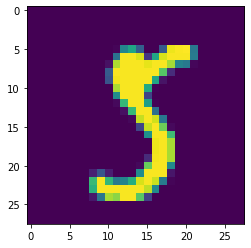

9


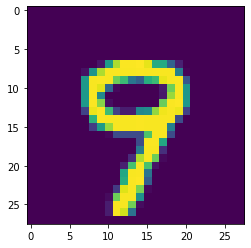

7


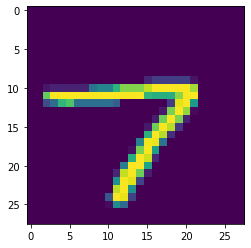

4


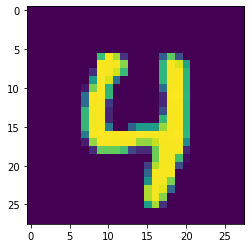

8


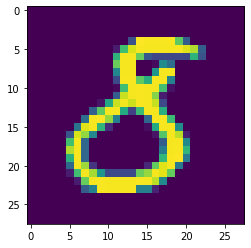

In [8]:
# Explore data
## YOUR CODE HERE ##
first_image, first_label = training_data[0]
print(f"Image size: {first_image.size()}")
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
## YOUR CODE HERE ##
class MnistMLP(nn.Module):
    def __init__(self):
        super(MnistMLP, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        dropout = 0.3
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.dropout_1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.dropout_2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_2, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.dropout_1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout_2(x)
        x = self.fc3(x)
        return x

net = MnistMLP()
net.to(device)

MnistMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout_2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
def train_one_epoch(net, train_loader, device, criterion, optimizer):
    net.train()
    train_loss = 0.0
    train_acc_history = []
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_acc_history.append(100.0 * (preds == labels).sum().item() / preds.size(0))
        train_loss += loss.item() * inputs.size(0)
    train_correct = np.mean(train_acc_history)
    train_loss /= len(train_loader.dataset)
    return train_loss, train_correct
    
def test_one_epoch(net, test_loader, device, criterion=None):
    test_loss = 0.0
    test_acc_history = []
    with torch.no_grad():
        net.eval()
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            if criterion:
                loss = criterion(outputs, labels)
                test_loss += (1 / (1 + batch_idx)) * (loss.data.item() - test_loss)

            _, preds = torch.max(outputs.data, 1)
            test_acc_history.append(100 * (preds == labels).sum().item() / preds.size(0))
    test_correct = np.mean(test_acc_history)
    return test_loss, test_correct


def train_network(net, train_loader, val_loader, device, criterion, optimizer, num_epochs=10) -> (List[float], List[float], List[float], List[float]): 
    train_loss_history = list()
    train_accuracy_history = list()
    val_loss_history = list()
    val_accuracy_history = list()

    for epoch in range(num_epochs):
        train_loss, train_correct = train_one_epoch(net, train_loader, device, criterion, optimizer)
        print(f'Epoch {epoch + 1} training accuracy: {train_correct:.2f}% training loss: {train_loss:.5f}')
        train_loss_history.append(train_loss)    
        train_accuracy_history.append(train_correct)

        val_loss, val_correct = test_one_epoch(net, val_loader, device, criterion=criterion)
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct:.2f}% validation loss: {val_loss:.5f}')
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_correct)  
        
    return (train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history)

In [11]:
def plot_network_training(train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    ax1.plot(train_loss_history, label="Training Loss")
    ax1.plot(val_loss_history, label="Validation Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("# epochs")
    ax1.legend()

    ax2.plot(train_accuracy_history, label="Training Accuracy")
    ax2.plot(val_accuracy_history, label="Validation Accuracy") 
    ax2.set_ylabel("% Accuracy")
    ax2.set_xlabel("# epochs")

    ax2.legend()    
    plt.show()
    

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
## YOUR CODE HERE ##
num_epochs = 10
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_network(net, train_loader, val_loader, device, criterion, optimizer, num_epochs)
                                                           

Epoch 1 training accuracy: 87.90% training loss: 0.38520
Epoch 1 validation accuracy: 93.40% validation loss: 0.21381
Epoch 2 training accuracy: 93.48% training loss: 0.21412
Epoch 2 validation accuracy: 94.98% validation loss: 0.17224
Epoch 3 training accuracy: 94.46% training loss: 0.18002
Epoch 3 validation accuracy: 95.52% validation loss: 0.14676
Epoch 4 training accuracy: 95.16% training loss: 0.15676
Epoch 4 validation accuracy: 96.42% validation loss: 0.12577
Epoch 5 training accuracy: 95.29% training loss: 0.15114
Epoch 5 validation accuracy: 96.78% validation loss: 0.11202
Epoch 6 training accuracy: 95.82% training loss: 0.13431
Epoch 6 validation accuracy: 96.38% validation loss: 0.12219
Epoch 7 training accuracy: 96.10% training loss: 0.12538
Epoch 7 validation accuracy: 96.97% validation loss: 0.10697
Epoch 8 training accuracy: 96.16% training loss: 0.12235
Epoch 8 validation accuracy: 97.09% validation loss: 0.10359
Epoch 9 training accuracy: 96.49% training loss: 0.11457

Plot the training loss (and validation loss/accuracy, if recorded).

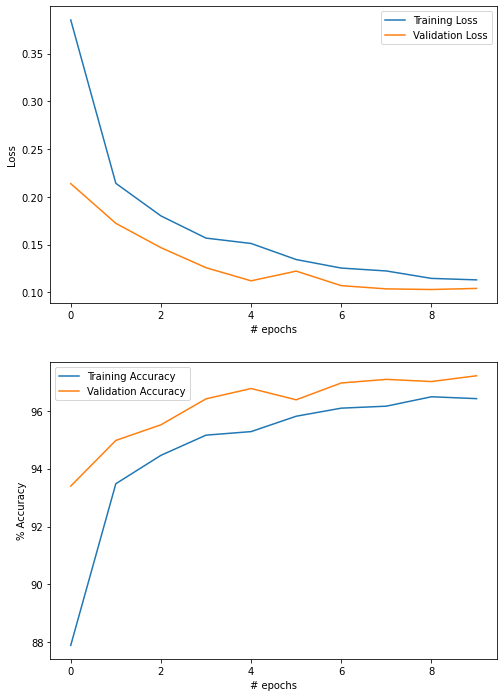

In [13]:
## YOUR CODE HERE ##
plot_network_training(train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
## YOUR CODE HERE ##
_, test_correct = test_one_epoch(net, test_loader, device)
print(f'Test accuracy: {test_correct:.2f}%')


Test accuracy: 97.43%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Increased the number of nodes in the hidden layers to counter underfitting going from hidden_1 = 256 and hidden_2 = 64 to eventually 512 in each. Implemented dropout to prevent overcompensation by overfitting. Used the MLP model in CNN section as reference to arrive at the hyperparameters to take the network beyond 90% accuracy.

## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), "mnist_trained_network.pt")